# Survival Estimates that Vary with Time

- Censored Data
- Kaplan-Meier Estimates
- Subgroup Analysis

In [1]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from assignments.C2_W3.util import load_data

from lifelines import KaplanMeierFitter as KM
from lifelines.statistics import logrank_test

In [2]:
data = load_data()

In [3]:
print(data.shape)
data.head()

(80, 3)


,Stage_group,Time,Event
0,1,6,1
1,1,19,1
2,1,32,1
3,1,42,1
4,1,42,1


- `Time` states how long the patient lived before they dies or was censored,
- `Event` says whether a death was observed or not. `1` is died, `-` is censored,

Censorship here means that the observation has ended without any observed event. For example, let a patient ve in a hospital for 100 days at most. If a patient dies after only 44 days, their event will be recorded as `Time = 44` and `Event = 0`. If a patient survives for 25 years after being admitted, their data is still `Time = 100` and `Event = 0`.

### Censored Data

Text(0.5, 0, 'Frequency (number of patients)')

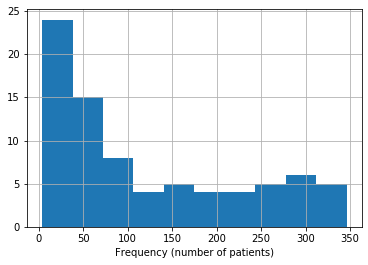

In [4]:
data.Time.hist()
plt.xlabel("Observation time before death or censorship (days)")
plt.xlabel("Frequency (number of patients)")

In [5]:
def frac_censored(df):
    result = 0.0
    
    result = sum(df['Event'] == 0) / len(df)
    
    return result

In [6]:
frac_censored(data)

0.325

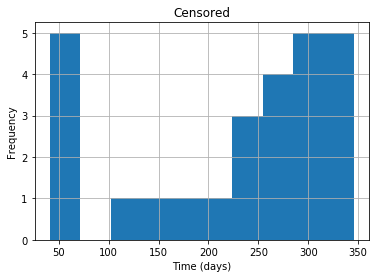

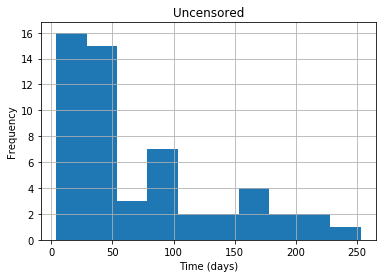

In [7]:
df_censored = data[data.Event == 0]
df_uncensored = data[data.Event == 1]

df_censored.Time.hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

df_uncensored.Time.hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

#### Survival Estimates

The survival function:

$$
S(t) = P(T > t)
$$

To illusttrate the strenghts of Kaplan-Meier, we'll start with a naive estimator of the above survival function. To estimate this quantity, we'll divide the number of people who we know lived past time $t$ by the number of people who were not censored before $t$.

Formally, let $i$ = 1, ..., $n$ be the cases, and let $t_i$ be the time when $i$ was censored or an event happened. Let $e_i= 1$ if an event was observed for $i$ and 0 otherwise. Then let $X_t = \{i : T_i > t\}$, and let $M_t = \{i : e_i = 1 \text{ or } T_i > t\}$. The estimator you will compute will be:

$$
\hat{S}(t) = \frac{|X_t|}{|M_t|}
$$


In [8]:
def naive_estimator(t, df):
    S_t = 0.0
    
    X = 0.
    M = 0.
    
    for (i, row) in df.iterrows():
        if row["Time"] > t:
            M += 1
            X += 1
            continue
        if row["Event"] == 1:
            M += 1
    
    S_t = X/M
    
    return S_t

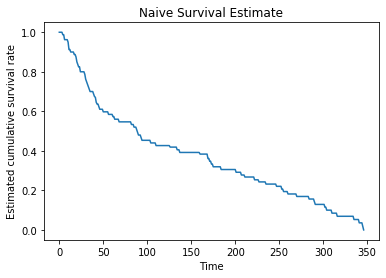

In [9]:
max_time = data.Time.max()
x = range(0, max_time+1)
y = np.zeros(len(x))
for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)
    
plt.plot(x, y)
plt.title('Naive Survival Estimate')
plt.xlabel("Time")
plt.ylabel("Estimated cumulative survival rate")
plt.show()

Kaplan-Meier estimate:


$$
S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})
$$

where $t_i$ are the events observed in the dataset and $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of people who we know have survived up to time $t_i$.

In [10]:
def homemadeKM(df):
    event_times = [0]
    p = 1.
    S = [p]
    
    observed_event_times = list(set(df["Time"]))
    
    observed_event_times.sort()
    
    for t in observed_event_times:
        n_t = sum(df["Time"] >= t)
        
        d_t = sum((df["Time"] == t) & (df["Event"] == 1))

        p *= 1 - (d_t / n_t)
        
        S.append(p)
        event_times.append(t)
    
    return event_times, S

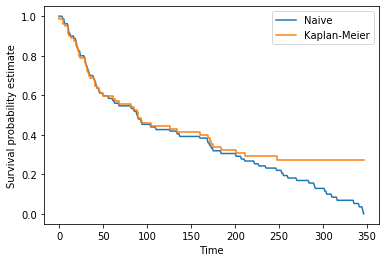

In [11]:
max_time = data.Time.max()
x = range(0, max_time + 1)
y = np.zeros(len(x))
for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)

plt.plot(x, y, label="Naive")

x, y = homemadeKM(data)
plt.step(x, y, label="Kaplan-Meier")
plt.xlabel("Time")
plt.ylabel("Survival probability estimate")
plt.legend()
plt.show()

### Subgroup Analysis

There's a column called `Stage_group`.
- a value of `1` denotes a patient with stage III cancer,
- a value of `2` decontes stage VI,

We want to compare the survival functions of these two groups.

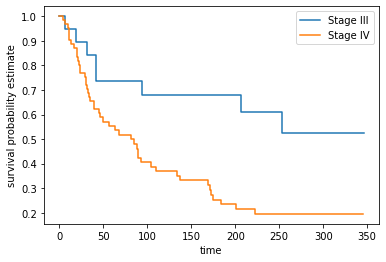

In [13]:
S1 = data[data.Stage_group == 1]
km1 = KM()
km1.fit(S1.loc[:, 'Time'], event_observed = S1.loc[:, 'Event'], label = "Stage III")

S2 = data[data.Stage_group == 2]
km2 = KM()
km2.fit(S2.loc[:, 'Time'], event_observed = S2.loc[:, 'Event'], label = "Stage IV")

ax = km1.plot(ci_show=False)
km2.plot(ax = ax, ci_show = False)
plt.xlabel('time')
plt.ylabel('survival probability estimate')
plt.savefig("two_km_curves", dpi=300)

Comparing the survival functions at 90, 180, 270 and 360 days.

In [15]:
survivals = pd.DataFrame([90, 180, 270, 360], columns = ['time'])
survivals.loc[:, 'Group 1'] = km1.survival_function_at_times(survivals['time']).values
survivals.loc[:, 'Group 2'] = km2.survival_function_at_times(survivals['time']).values

In [16]:
survivals

,time,Group 1,Group 2
0,90,0.736842,0.424529
1,180,0.680162,0.254066
2,270,0.524696,0.195436
3,360,0.524696,0.195436


#### Log-Rank Test

To say whether ther's a statistical difference between the survival curves, we can run the log-rank test.

This test tells us the probability that we could observe this data, if the two curves were the same. The derivation of the log-rank test is somewhat complicated, but luckily `lifelines` has a simple function to compute it.

In [17]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(group_1_data.Time, group_2_data.Time,
                         group_1_data.Event, group_2_data.Event)
    return result.p_value

logrank_p_value(S1, S2)

0.009588929834755544

If the p value is less than `0.05`, this indicates, that the difference in the curves is statistically significant.